In [1]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from skimage.io import imread as imread
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
from skimage.color import label2rgb
image_dir = Path('..') / 'input' / 'skin-cancer-mnist-ham10000'
mapping_file = Path('..') / 'input' / 'skin-images-to-features' / 'color_features.json'
skin_df = pd.read_json(mapping_file)
#skin_df['image_path'] = skin_df['image_path'].map(lambda x: image_dir / 'subset' / x) 
print(skin_df['image_path'].map(lambda x: Path(x).exists()).value_counts())
skin_df.sample(2)

True    9958
Name: image_path, dtype: int64


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,dx_name,dx_id,color_features
2752,HAM_0002744,ISIC_0031236,bcc,histo,45,female,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,basal cell carcinoma,2,"[3.7037000000000002e-06, 0.0, 0.0, 0.0, 0.0, 0..."
1247,HAM_0001726,ISIC_0029281,mel,histo,35,female,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,melanoma,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Split up the groups so we can validate our model on something besides the direct training data

In [4]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(skin_df, 
                 test_size = 0.3, 
                  # hack to make stratification work                  
                 stratify = skin_df['dx_id'])
print(raw_train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

6970 training masks
2988 validation masks


# Model Parameters

In [5]:
GAUSSIAN_NOISE = 0.05
# number of validation images to use
VALID_IMG_COUNT = 1500
BASE_MODEL='MobileNet' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 256
SAMPLE_PER_GROUP = 2200
LEARN_RATE = 2e-4
EPOCHS = 25
FLATTEN = True
RGB_FLIP = 1 # should rgb be flipped when rendering images

In [6]:
train_df = raw_train_df.\
     groupby('dx_name').\
     apply(lambda x: x.sample(SAMPLE_PER_GROUP//2, replace=True)).\
     reset_index(drop=True)
train_df.shape[0]

7700

# Prepare for Model

In [7]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL == 'MobileNet':
    from keras.applications.mobilenet_v2 import MobileNetV2 as PTModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.


In [8]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.7, 1.3],
                   
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)

valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [9]:
def flow_from_dataframe(img_data_gen, raw_df, path_col, y_col, **dflow_args):
    """Keras update makes this much easier"""
    in_df = raw_df.copy()
    in_df[path_col] = in_df[path_col].map(str)
    in_df[y_col] = in_df[y_col].map(lambda x: np.array(x))
    df_gen = img_data_gen.flow_from_dataframe(in_df, 
                                              x_col=path_col,
                                              y_col=y_col,
                                    class_mode = 'raw',
                                    **dflow_args)
    # posthoc correction
    df_gen._targets = np.stack(df_gen.labels, 0)
    return df_gen

In [10]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'image_path',
                            y_col = 'dx_id', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'image_path',
                            y_col = 'dx_id', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

Found 7700 validated image filenames.
Found 2988 validated image filenames.
(1500, 224, 224, 3) (1500,)


x (64, 224, 224, 3) float32 -1.0 1.0
y (64,) int64 0 6


Text(0.5, 1.0, 'images')

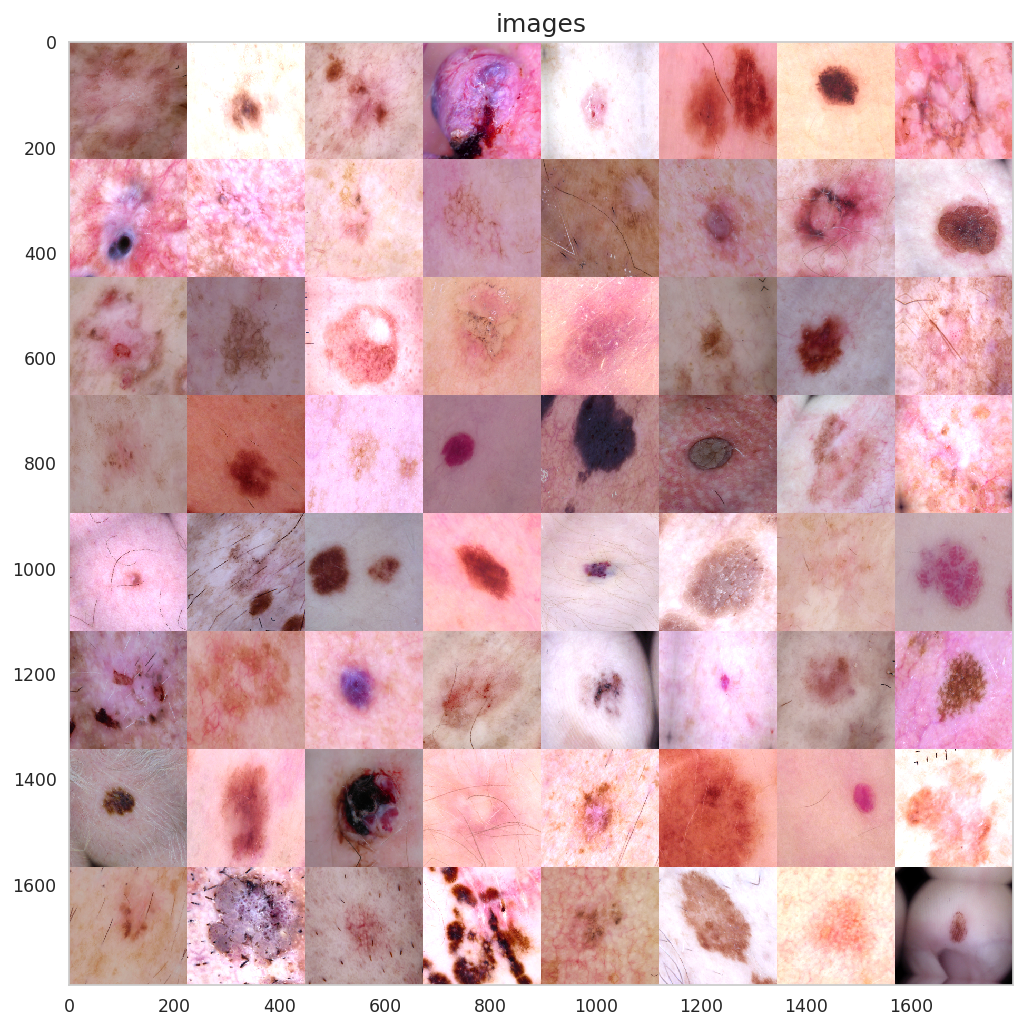

In [11]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(montage_rgb((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, ::RGB_FLIP])
ax1.set_title('images')

### Show the labels
Here we show the labels for the batch items and can see how frequent each one is

(array([ 9.,  7.,  0., 11.,  0., 12.,  9.,  0.,  9.,  7.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

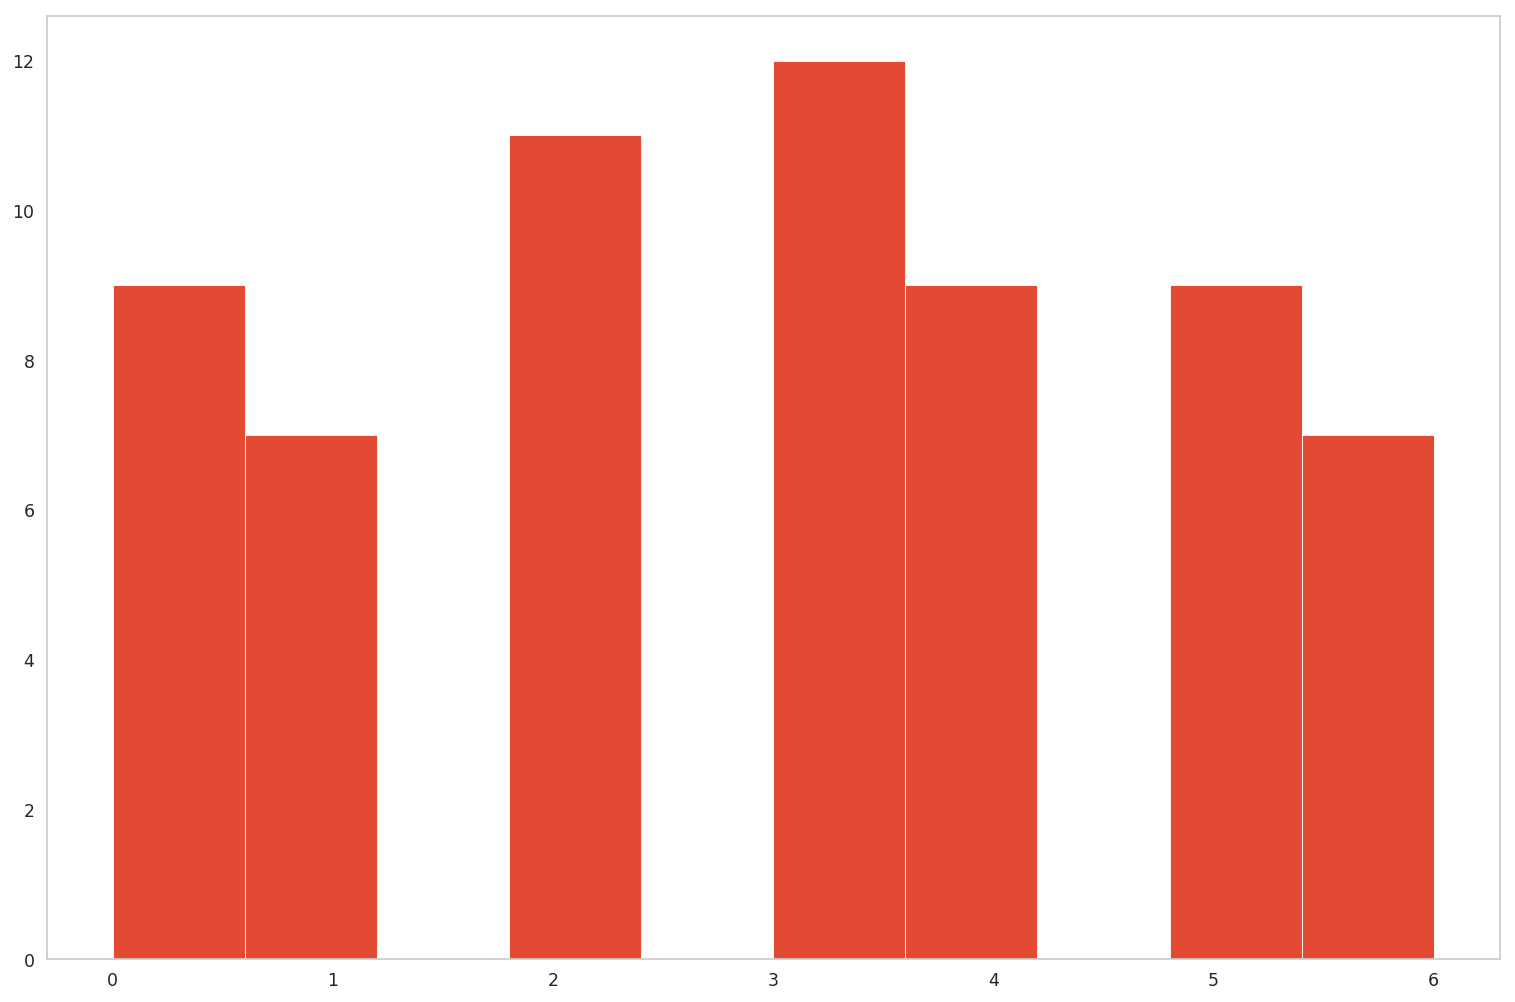

In [12]:
plt.hist(t_y.T)

# Build a Model

In [13]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [14]:
from keras import models, layers
from keras.optimizers import Adam
img_in = layers.Input(t_x.shape[1:], name='Image_RGB_In')
img_noise = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
pt_features = base_pretrained_model(img_noise)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
bn_features = layers.BatchNormalization()(pt_features)
feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features)
if FLATTEN:
    flat_layer = layers.Flatten()(bn_features)
    collapsed_layer = layers.Dropout(DROPOUT)(flat_layer)
else:
    collapsed_layer = layers.GlobalAvgPool2D()(bn_features)
dr_steps = layers.Dropout(DROPOUT)(layers.Dense(DENSE_COUNT, activation = 'relu')(collapsed_layer))
out_layer = layers.Dense(train_df['dx_id'].max()+1, activation = 'softmax')(dr_steps)

skin_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

skin_model.compile(optimizer = Adam(lr=LEARN_RATE), 
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['sparse_categorical_accuracy'])

skin_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_RGB_In (InputLayer)    (None, 224, 224, 3)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 1280)        5120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16056576  
__________

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('skin_cancer_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
train_gen.batch_size = BATCH_SIZE
fit_results = skin_model.fit_generator(train_gen, 
                            steps_per_epoch = train_gen.samples//BATCH_SIZE,
                      validation_data = (valid_x, valid_y), 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list,
                      workers = 3)
clear_output()

Epoch 1/25
120/120 [==============================] - 364s 3s/step - loss: 1.8077 - sparse_categorical_accuracy: 0.3802 - val_loss: 1.6310 - val_sparse_categorical_accuracy: 0.3847

Epoch 00001: val_loss improved from inf to 1.63095, saving model to skin_cancer_detector_weights.best.hdf5
Epoch 2/25
120/120 [==============================] - 367s 3s/step - loss: 1.3941 - sparse_categorical_accuracy: 0.4820 - val_loss: 1.5695 - val_sparse_categorical_accuracy: 0.4633

Epoch 00002: val_loss improved from 1.63095 to 1.56949, saving model to skin_cancer_detector_weights.best.hdf5
Epoch 3/25
120/120 [==============================] - 366s 3s/step - loss: 1.3113 - sparse_categorical_accuracy: 0.5238 - val_loss: 1.3391 - val_sparse_categorical_accuracy: 0.5727

Epoch 00003: val_loss improved from 1.56949 to 1.33907, saving model to skin_cancer_detector_weights.best.hdf5
Epoch 4/25
120/120 [==============================] - 380s 3s/step - loss: 1.2502 - sparse_categorical_accuracy: 0.5428 - val

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.plot(fit_results.history['loss'], label='Training')
ax1.plot(fit_results.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(fit_results.history['sparse_categorical_accuracy'], label='Training')
ax2.plot(fit_results.history['val_sparse_categorical_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Binary Accuracy')
ax2.set_ylim(0, 1)

In [ ]:
skin_model.load_weights(weight_path)
skin_model.save('full_skin_cancer_model.h5')

In [ ]:
for k, v in zip(skin_model.metrics_names, 
        skin_model.evaluate(valid_x, valid_y)):
    if k!='loss':
        print('{:40s}:\t{:2.1f}%'.format(k, 100*v))

In [ ]:
dx_lookup_dict = train_df[['dx_name', 'dx_id']].drop_duplicates().set_index('dx_id').to_dict()['dx_name']

In [ ]:
t_x, t_y = next(train_gen)
t_yp = skin_model.predict(t_x)
fig, (m_axs) = plt.subplots(4, 4, figsize = (20, 20))
for i, c_ax in enumerate(m_axs.flatten()):
    c_ax.imshow(((t_x[i]-t_x.min())/(t_x.max()-t_x.min()))[:, ::RGB_FLIP])
    c_title = '{}\nPred: {:2.1f}%'.format(dx_lookup_dict[t_y[i]], 100*t_yp[i, t_y[i]])
    c_ax.set_title(c_title)
    c_ax.axis('off')

# Validation Data Results
Here we show the results on validation data

In [ ]:
t_x, t_y = valid_x, valid_y
t_yp = skin_model.predict(t_x, batch_size=8, verbose=True)
fig, (m_axs) = plt.subplots(4, 4, figsize = (20, 20))
for i, c_ax in enumerate(m_axs.flatten()):
    c_ax.imshow(((t_x[i]-t_x.min())/(t_x.max()-t_x.min()))[:, ::RGB_FLIP])
    c_title = '{}\nPred: {:2.1f}%'.format(dx_lookup_dict[t_y[i]], 100*t_yp[i, t_y[i]])
    c_ax.set_title(c_title)
    c_ax.axis('off')

## Detailed Performance by group

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
skin_conditions = [dx_lookup_dict[k][:20] for k in range(len(dx_lookup_dict))]
t_y_ohe = ohe.fit_transform(t_y.reshape(-1, 1))
pred_df = pd.concat([
    pd.DataFrame(t_yp, columns=skin_conditions).assign(source='Prediction').assign(id=range(t_yp.shape[0])),
    pd.DataFrame(t_y_ohe, columns=skin_conditions).assign(source='Ground-truth').assign(id=range(t_yp.shape[0]))
])
flat_pred_df = pd.melt(pred_df, id_vars=['source', 'id']).pivot_table(index=['id', 'variable'], columns='source', values='value').reset_index()
flat_pred_df['Ground-truth'] = flat_pred_df['Ground-truth'].map(lambda x: 'Positive' if x>0.5 else 'Negative')
sns.catplot(data=flat_pred_df, x='Ground-truth', y='Prediction', col='variable', kind='swarm',  col_wrap=4)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
sns.swarmplot(data=flat_pred_df, hue='Ground-truth', y='Prediction', x='variable', size=2.0, ax=ax1)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
sns.boxplot(data=flat_pred_df, hue='Ground-truth', y='Prediction', x='variable', ax=ax1)

## Class-level ROC curves

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
for i, c_all in enumerate(skin_conditions):
    tpr, fpr, thresh = roc_curve(y_true=t_y_ohe[:, i], y_score=t_yp[:, i])
    auc_roc = roc_auc_score(y_true=t_y_ohe[:, i], y_score=t_yp[:, i])
    ax1.plot(tpr, fpr, '.-', label='{} (AUC:{:2.1%})'.format(c_all, auc_roc), lw=2)
ax1.legend()

# Export the Model
We can export the model to tensorflowjs to build a web-app that can automatically predict what allergens are in a given image 

In [ ]:
skin_model.get_input_at(0), skin_model.get_output_at(0)